In [1]:
import os, sys


import matplotlib.pyplot as plt
import arviz as az
import numpy as np

import privugger as pv


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Governor tutorial

In [2]:
def Gov(names, zips, ages, genders, diagnoses):
    output = []
    output.append(zips)
    output.append(ages)
    output.append(genders)
    output.append(diagnoses)
    return output

In [3]:
N = 10
        
alice_name      = pv.Constant("alice_name",0, num_elements=1)
alice_age       = pv.Constant("alice_age", 25.0, num_elements=1)
alice_zip       = pv.Constant("alice_zip",50, num_elements=1)
alice_gender    = pv.Constant("alice_gender",1, num_elements=1) # 1: female, 0: male
alice_diagnosis = pv.Constant("alice_diagnosis", 1, num_elements=1) # 0: healthy, 1: ill
    
names           = pv.DiscreteUniform("names", 0, 5, num_elements=N)
ages            = pv.Normal("ages", mu=55.2, std=3.5, num_elements=N)
zips            = pv.DiscreteUniform("zips", 0, 100, num_elements=N)
genders         = pv.Bernoulli("genders",p=.5,num_elements=N)   
diagnoses       = pv.Bernoulli("diagnoses", p=.2,num_elements=N)

names_          = pv.concatenate(names, alice_name,  "discrete")
zips_           = pv.concatenate(zips, alice_zip, "discrete")
ages_           = pv.concatenate(ages, alice_age,  "continuous")
genders_        = pv.concatenate(genders, alice_gender, "discrete")
diagnoses_      = pv.concatenate(diagnoses, alice_diagnosis, "discrete")

In [4]:
ds        = pv.Dataset(input_specs = [names_, zips_, ages_, genders_, diagnoses_])

program   = pv.Program(dataset=ds, name="Governor", output_type=pv.Matrix(pv.Float), function=Gov)
trace     = pv.infer(program, cores=4, draws=10000, method='pymc3', return_model=False)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alice_diagnosis]
>>Metropolis: [alice_gender]
>>Metropolis: [alice_age]
>>Metropolis: [alice_zip]
>>Metropolis: [zips]
>>Metropolis: [alice_name]
>>Metropolis: [names]
>NUTS: [ages]
>BinaryGibbsMetropolis: [genders, diagnoses]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
/home/rasmuscarl/.local/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
cores=4
samples=10000
names_db     = trace.posterior['names_'].values
ages_db      = trace.posterior['ages_'].values[0]
genders_db   = trace.posterior['genders_'].values[0]
diagnoses_db = trace.posterior['diagnoses_'].values[0]
zips_db      = trace.posterior['zips_'].values[0]

print("Rows with gov's gender: ",sum([np.count_nonzero(genders_db[i]==1) for i in range(0,len(genders_db))])/len(genders_db))
print("Rows with gov's name: ",sum([np.count_nonzero(names_db[i]==0) for i in range(0,len(names_db))])/len(names_db))
print("Rows with gov's diagnosis: ",sum([np.count_nonzero(diagnoses_db[i]==1) for i in range(0,len(diagnoses_db))])/len(diagnoses_db))
print("Rows with gov's zip: ",sum([np.count_nonzero(zips_db[i]==50) for i in range(0,len(zips_db))])/len(zips_db))

Rows with gov's gender:  501.0787
Rows with gov's name:  320000.0
Rows with gov's diagnosis:  201.0668
Rows with gov's zip:  15.1097


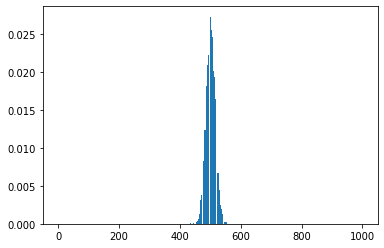

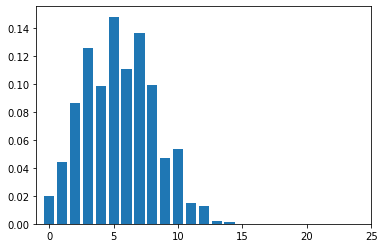

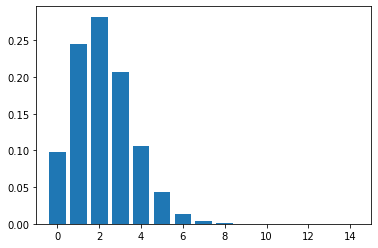

In [25]:
total_samples=len(genders_db)
total_N=N

count_gov_genders=np.array([np.count_nonzero(
    (genders_db[i]==1)
) for i in range(0,total_samples)])

count_gov_zips=np.array([np.count_nonzero(
    (zips_db[i]==1)
) for i in range(0,total_samples)])

count_gov_genders_zips=np.array([np.count_nonzero(
    (zips_db[i]==100) &
    (genders_db[i]==1)
) for i in range(0,total_samples)])


y1=[np.count_nonzero(count_gov_genders==i)/len(count_gov_genders) for i in range(0,total_N)]
y2=[np.count_nonzero(count_gov_zips==i)/len(count_gov_zips) for i in range(0,total_N)]
y3=[np.count_nonzero(count_gov_genders_zips==i)/len(count_gov_genders_zips) for i in range(0,total_N)]
plt.bar(range(0,total_N),y1)
plt.show()
plt.bar(range(0,total_N),y2)
plt.xlim((-1,25))
plt.show()
plt.bar(range(0,total_N),y3)
plt.xlim((-1,15))
plt.show()